In [1]:
import pandas as pd
import numpy as np
import sys

In [2]:
import transaction_demo

In [3]:
seed = 42

In [4]:
%matplotlib inline

### Load transactions

In [5]:
df = pd.read_csv('../data/transactions.csv')
df.head(10)

,Unnamed: 0,trans_id,account_id,date,type,operation,amount,balance,k_symbol,bank,account,mean_income
0,0,695247,2378,1993-01-01,1,2.0,700.0,700.0,NaN,NaN,NaN,[ 11271.53754941]
1,1,695250,2378,1993-01-22,1,2.0,7268.0,7968.0,NaN,NaN,NaN,[ 11271.53754941]
2,2,695266,2378,1993-01-23,1,2.0,14440.0,22408.0,NaN,NaN,NaN,[ 11271.53754941]
3,3,695262,2378,1993-01-24,1,2.0,49752.0,72160.0,NaN,NaN,NaN,[ 11271.53754941]
4,4,695265,2378,1993-01-26,1,2.0,21899.0,94059.0,NaN,NaN,NaN,[ 11271.53754941]
5,5,695560,2378,1993-01-31,0,3.0,34700.0,59453.7,NaN,NaN,NaN,[ 11271.53754941]
6,6,3608592,2378,1993-01-31,1,NaN,94.7,94153.7,2,NaN,NaN,[ 11271.53754941]
7,7,695272,2378,1993-02-05,1,2.0,30192.0,89645.7,NaN,NaN,NaN,[ 11271.53754941]
8,8,695340,2378,1993-02-07,0,0.0,9612.0,80033.7,4,EF,1222903.0,[ 11271.53754941]
9,9,695270,2378,1993-02-11,1,2.0,31038.0,111071.7,NaN,NaN,NaN,[ 11271.53754941]


### Clean the dataset

* Leave target columns only (date, operation and amount)
* filter out NaNs
* convert operations to int

In [6]:
df = transaction_demo.clean_dataset(df)
df.head(10)

,account_id,date,operation,amount
0,2378,1993-01-01,2,700.0
1,2378,1993-01-22,2,7268.0
2,2378,1993-01-23,2,14440.0
3,2378,1993-01-24,2,49752.0
4,2378,1993-01-26,2,21899.0
5,2378,1993-01-31,3,34700.0
7,2378,1993-02-05,2,30192.0
8,2378,1993-02-07,0,9612.0
9,2378,1993-02-11,2,31038.0
10,2378,1993-02-11,3,25200.0


Leave transaction only for the 1993 year:

In [7]:
df = df[pd.to_datetime(df['date']) < pd.to_datetime('1994-01-01')]

### Segment all transaction by month

We consider each month of an account as a separate segment. All segments are considered the same. It means our generator will generate a monthly snapshot of transactions for some user.

In [8]:
df = transaction_demo.segment_by_month(df)
df.head(10)

,date,operation,amount,day,segment_id
0,1993-01-01,2,700.0,1,2378:1993-01
1,1993-01-22,2,7268.0,22,2378:1993-01
2,1993-01-23,2,14440.0,23,2378:1993-01
3,1993-01-24,2,49752.0,24,2378:1993-01
4,1993-01-26,2,21899.0,26,2378:1993-01
5,1993-01-31,3,34700.0,31,2378:1993-01
7,1993-02-05,2,30192.0,5,2378:1993-02
8,1993-02-07,0,9612.0,7,2378:1993-02
9,1993-02-11,2,31038.0,11,2378:1993-02
10,1993-02-11,3,25200.0,11,2378:1993-02


### Prepare training data

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
transform_pipeline = Pipeline([
    ("vectorizer", transaction_demo.TransactionVectorizer(
        group_column='segment_id',
        value_column='amount',
        dim1_column='operation',
        dim2_column='day',
        dim1_size=4,
        dim2_size=32)),
    ("scale", StandardScaler(with_mean=False))
])

In [10]:
df_transformed = transform_pipeline.fit_transform(df)

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(df_transformed, test_size=0.3, random_state=seed)

### Train the model

In [12]:
from synthesized.modules.synth import AlphaSynth
from sklearn.metrics import mean_squared_error

# define the estimator. We will use L2 penalty to augment the generalizability of the encoder
alpha = AlphaSynth(n_epochs=100, n_hidden=250, learning_rate=0.01, batch_size=256, 
                 display_step=10, activation_function='relu', verbose=2, min_change = 1e-6, 
                 random_state=seed, clip=True, l2_penalty=1e-5, 
                 early_stopping=True)

# fit
alpha.fit(X_train)

# synthesize data
synthetic = alpha.feed_forward(X_test)

# get the error:
mse = ((X_test - synthetic) ** 2).sum(axis=1).sum() / X_test.shape[0]
print("\nTest MSE: %.4f" % mse)

Epoch: 1, cost=1.153548, time=0.1134 (sec)
Epoch: 11, cost=0.121560, time=0.1823 (sec)
Epoch: 21, cost=0.200832, time=0.0786 (sec)
Epoch: 31, cost=0.164261, time=0.0786 (sec)
Epoch: 41, cost=0.153981, time=0.0876 (sec)
Epoch: 51, cost=0.112735, time=0.1871 (sec)
Epoch: 61, cost=0.103115, time=0.1049 (sec)
Epoch: 71, cost=0.142811, time=0.0795 (sec)
Epoch: 81, cost=0.132826, time=0.0976 (sec)
Epoch: 91, cost=0.120568, time=0.0810 (sec)
Optimization complete after 100 epoch(s). Average epoch time: 0.1019 seconds

Test MSE: 13.2650


### Visualization of original and synthetic data

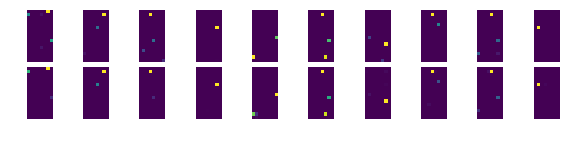

In [13]:
transaction_demo.show_data(X_test, synthetic)

### Convert synthetical data to transactions

In [17]:
df_orig = transform_pipeline.inverse_transform(X_test)
df_orig = transaction_demo.reconstruct_dates(df_orig, year=1993)
df_orig.head(10)

,segment_id,operation,amount,date
0,2506148334687292164,0,8618.0,1993-01-06
1,2506148334687292164,0,4068.0,1993-01-08
2,2506148334687292164,0,446.0,1993-01-12
3,2506148334687292164,2,16905.0,1993-01-15
4,2506148334687292164,2,1600.0,1993-01-28
5,2506148334687292164,3,14.6,1993-01-31
6,3179766089924039634,0,2933.0,1993-05-14
7,3179766089924039634,1,4896.0,1993-05-12
8,3179766089924039634,3,350.0,1993-05-08
9,3179766089924039634,3,14.6,1993-05-31


In [18]:
df_synth = transform_pipeline.inverse_transform(synthetic)
df_synth = transaction_demo.reconstruct_dates(df_synth, year=1993)
df_synth.head(10)

,segment_id,operation,amount,date
0,2641295384772927429,0,9555.61,1993-10-06
1,2641295384772927429,0,6179.85,1993-10-08
2,2641295384772927429,2,4070.07,1993-10-15
3,4594467458790881942,0,2392.43,1993-03-14
4,4594467458790881942,1,4965.42,1993-03-12
5,756246092357056518,0,13327.41,1993-07-11
6,756246092357056518,2,6869.67,1993-07-12
7,3724899965266696800,1,4830.57,1993-01-14
8,3724899965266696800,3,17.11,1993-01-11
9,800131921708171716,2,34691.11,1993-01-07


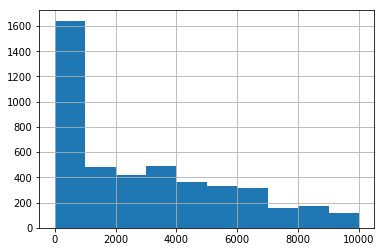

In [19]:
df_orig['amount'].hist(bins=10, range=[0,10000.0])

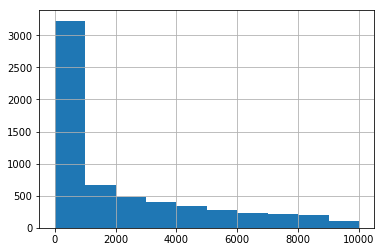

In [20]:
df_synth['amount'].hist(bins=10, range=[0,10000.0])

### Linkage attack test

In [121]:
from synthesized.testing.linkage_attack import linkage_attack, t_closeness_check

Find vulnerabilities in the original dataset:

In [122]:
vulnerabilities_orig = t_closeness_check(df_orig)

The total number of vulnerabilities:

Find the remaining vulnerabilities in the synthetical data:

In [124]:
vulnerabilities_remaining = linkage_attack(df_orig, df_synth, categ_columns={'operation', 'day'}, t_closeness=0.2, k_distance=0.8)

The number of remaining vulnerabilities in synthetical data:

### Percent of remaining vulnerabilities:

In [127]:
print('{:.2f}%'.format(len(vulnerabilities_remaining) / len(vulnerabilities_orig) * 100))

9.89%
